In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.utils import resample

import statsmodels.api as sm
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iml_term_project_2023/sample_submission.csv
/kaggle/input/iml_term_project_2023/train.csv
/kaggle/input/iml_term_project_2023/test.csv


In [2]:
df=pd.read_csv("/kaggle/input/iml_term_project_2023/train.csv")
df_test=pd.read_csv("/kaggle/input/iml_term_project_2023/test.csv")
df.head()

,Id,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,parentspecies,...,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,pSat_Pa
0,0,30.010565,4,1,1,0,0,1,1,apin_decane_toluene,...,0,0,0,0,0,0,0,0,0,641974.491
1,1,74.995643,6,1,3,1,0,1,1,toluene,...,0,0,1,0,0,0,0,0,0,10295.712
2,2,102.990558,8,2,4,1,0,2,2,toluene,...,0,0,1,0,0,0,0,0,0,13517.575
3,3,118.985472,9,2,5,1,1,3,1,toluene,...,0,0,1,0,0,0,0,0,0,241.630
4,4,134.980387,10,2,6,1,1,3,3,toluene,...,0,0,1,0,0,0,0,1,0,315.357


In [3]:
df["target"]=np.log10(df["pSat_Pa"])
df=df.drop(columns=["pSat_Pa","Id"])
df["target"].head()

0    5.807518
1    4.012656
2    4.130899
3    2.383151
4    2.498802
Name: target, dtype: float64

# EDA

## summary and missing data

In [4]:
#lets' see summary for the data set
df.describe()

,MW,NumOfAtoms,NumOfC,NumOfO,NumOfN,NumHBondDonors,NumOfConf,NumOfConfUsed,C.C..non.aromatic.,C.C.C.O.in.non.aromatic.ring,...,ether..alicyclic.,nitrate,nitro,aromatic.hydroxyl,carbonylperoxynitrate,peroxide,hydroperoxide,carbonylperoxyacid,nitroester,target
count,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,...,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000,27147.000000
mean,264.436315,26.232843,6.860611,9.928390,1.060964,2.201643,229.643386,25.721921,0.092865,0.012893,...,0.205142,0.665525,0.154050,0.001105,0.241389,0.279663,0.772977,0.259181,0.012451,-3.854276
std,49.858355,5.240883,1.451855,2.494574,0.712067,1.018979,202.905589,14.687277,0.290629,0.126076,...,0.403813,0.673048,0.366171,0.047001,0.451312,0.448842,0.698533,0.467085,0.112537,2.178311
min,30.010565,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-13.789350
25%,232.980781,23.000000,6.000000,8.000000,1.000000,2.000000,72.000000,11.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.247255
50%,266.986260,26.000000,7.000000,10.000000,1.000000,2.000000,174.000000,30.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-3.808918
75%,299.012475,30.000000,7.000000,12.000000,2.000000,3.000000,331.000000,40.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-2.400747
max,386.044503,41.000000,10.000000,17.000000,2.000000,6.000000,1743.000000,40.000000,2.000000,2.000000,...,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000,4.000000,3.000000,2.000000,5.864807


In [5]:
#let's check if there are any missing data 
df.isnull().sum()

MW                                0
NumOfAtoms                        0
NumOfC                            0
NumOfO                            0
NumOfN                            0
NumHBondDonors                    0
NumOfConf                         0
NumOfConfUsed                     0
parentspecies                   206
C.C..non.aromatic.                0
C.C.C.O.in.non.aromatic.ring      0
hydroxyl..alkyl.                  0
aldehyde                          0
ketone                            0
carboxylic.acid                   0
ester                             0
ether..alicyclic.                 0
nitrate                           0
nitro                             0
aromatic.hydroxyl                 0
carbonylperoxynitrate             0
peroxide                          0
hydroperoxide                     0
carbonylperoxyacid                0
nitroester                        0
target                            0
dtype: int64

In [6]:
#only parentspecies have missing data
print("Missing data of parentspecies = "+str((df["parentspecies"].isnull().sum()/len(df["MW"]))*100 )+ "%")
#it is less than 1%: we may drop them or we can replace them with mean or KNN if needed 
#(and if suitable not sure yet)

Missing data of parentspecies = 0.758831546763915%


In [7]:
df.columns

Index(['MW', 'NumOfAtoms', 'NumOfC', 'NumOfO', 'NumOfN', 'NumHBondDonors',
       'NumOfConf', 'NumOfConfUsed', 'parentspecies', 'C.C..non.aromatic.',
       'C.C.C.O.in.non.aromatic.ring', 'hydroxyl..alkyl.', 'aldehyde',
       'ketone', 'carboxylic.acid', 'ester', 'ether..alicyclic.', 'nitrate',
       'nitro', 'aromatic.hydroxyl', 'carbonylperoxynitrate', 'peroxide',
       'hydroperoxide', 'carbonylperoxyacid', 'nitroester', 'target'],
      dtype='object')

# Overview 
## relation of each feature with the target

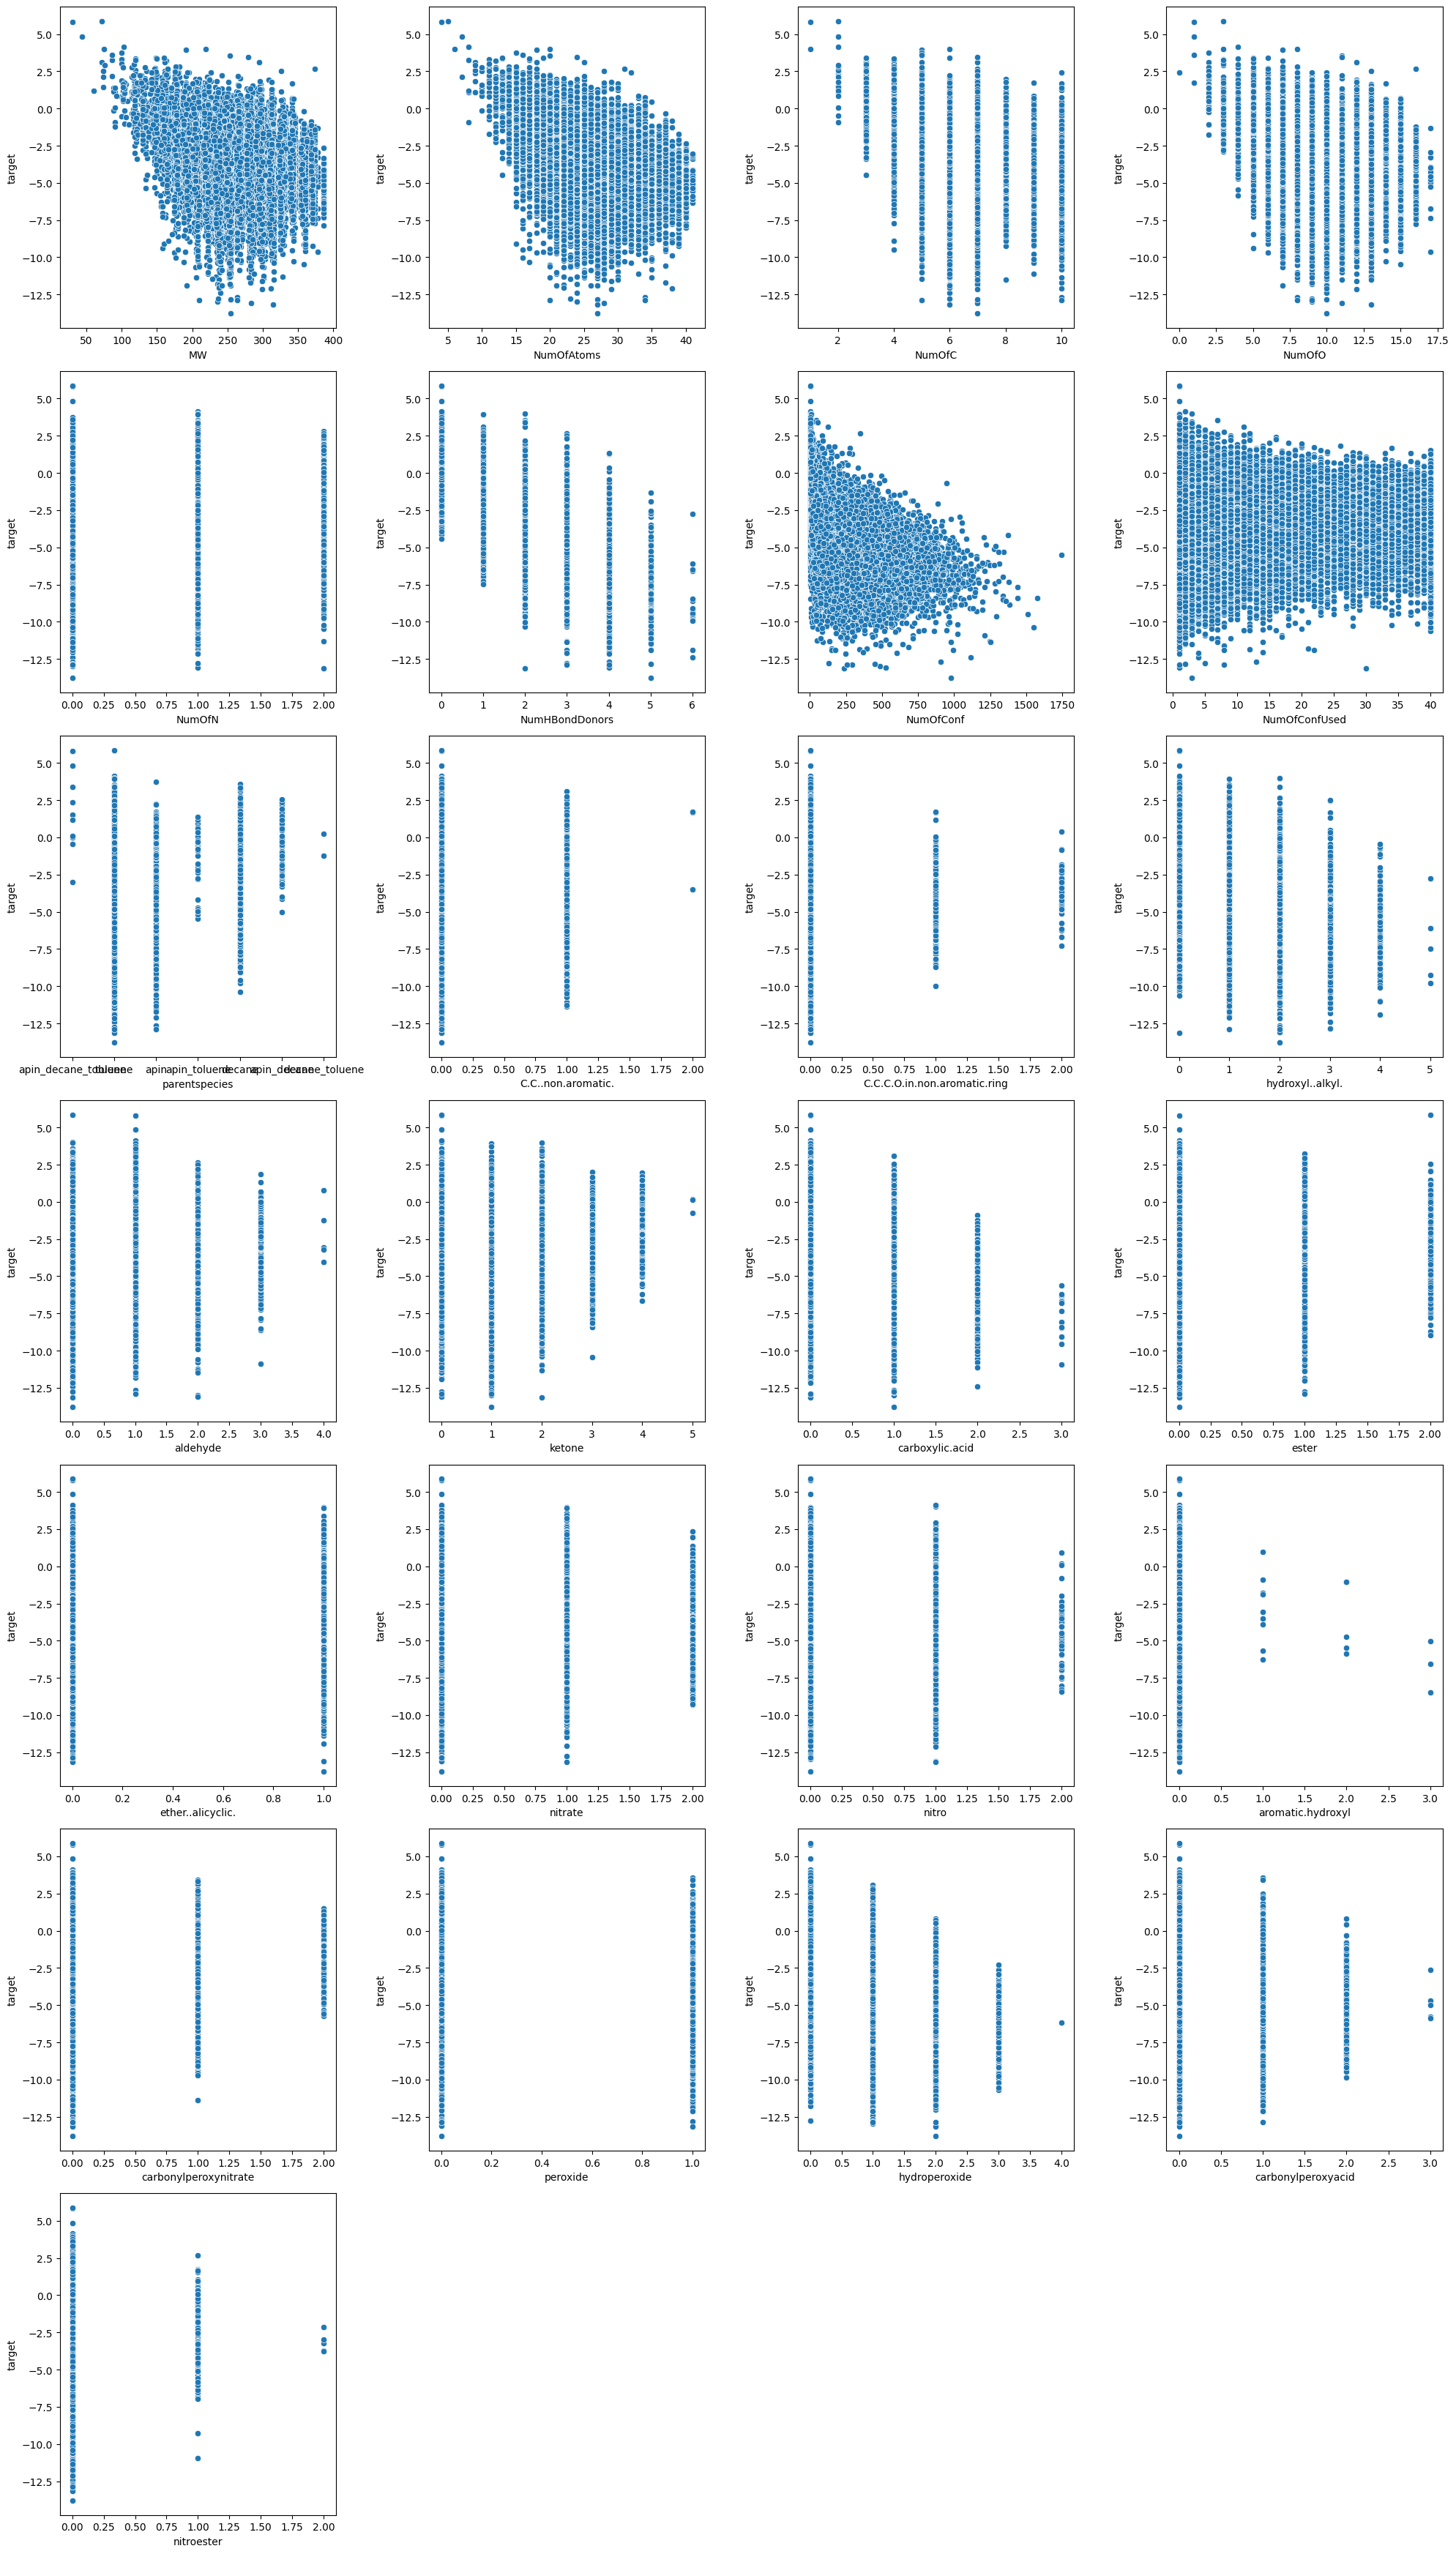

In [8]:
features = [col for col in df.columns if col != 'target']
n = len(features)
rows = n // 4 if n % 4 == 0 else n // 4 + 1

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

for i, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y='target', ax=axs[i//4, i%4])

# Remove empty subplots
if n % 4 != 0:
    for i in range(n, rows*4):
        fig.delaxes(axs.flatten()[i])
plt.tight_layout()
plt.show()


## Relation of the log transformation of each feature with the target

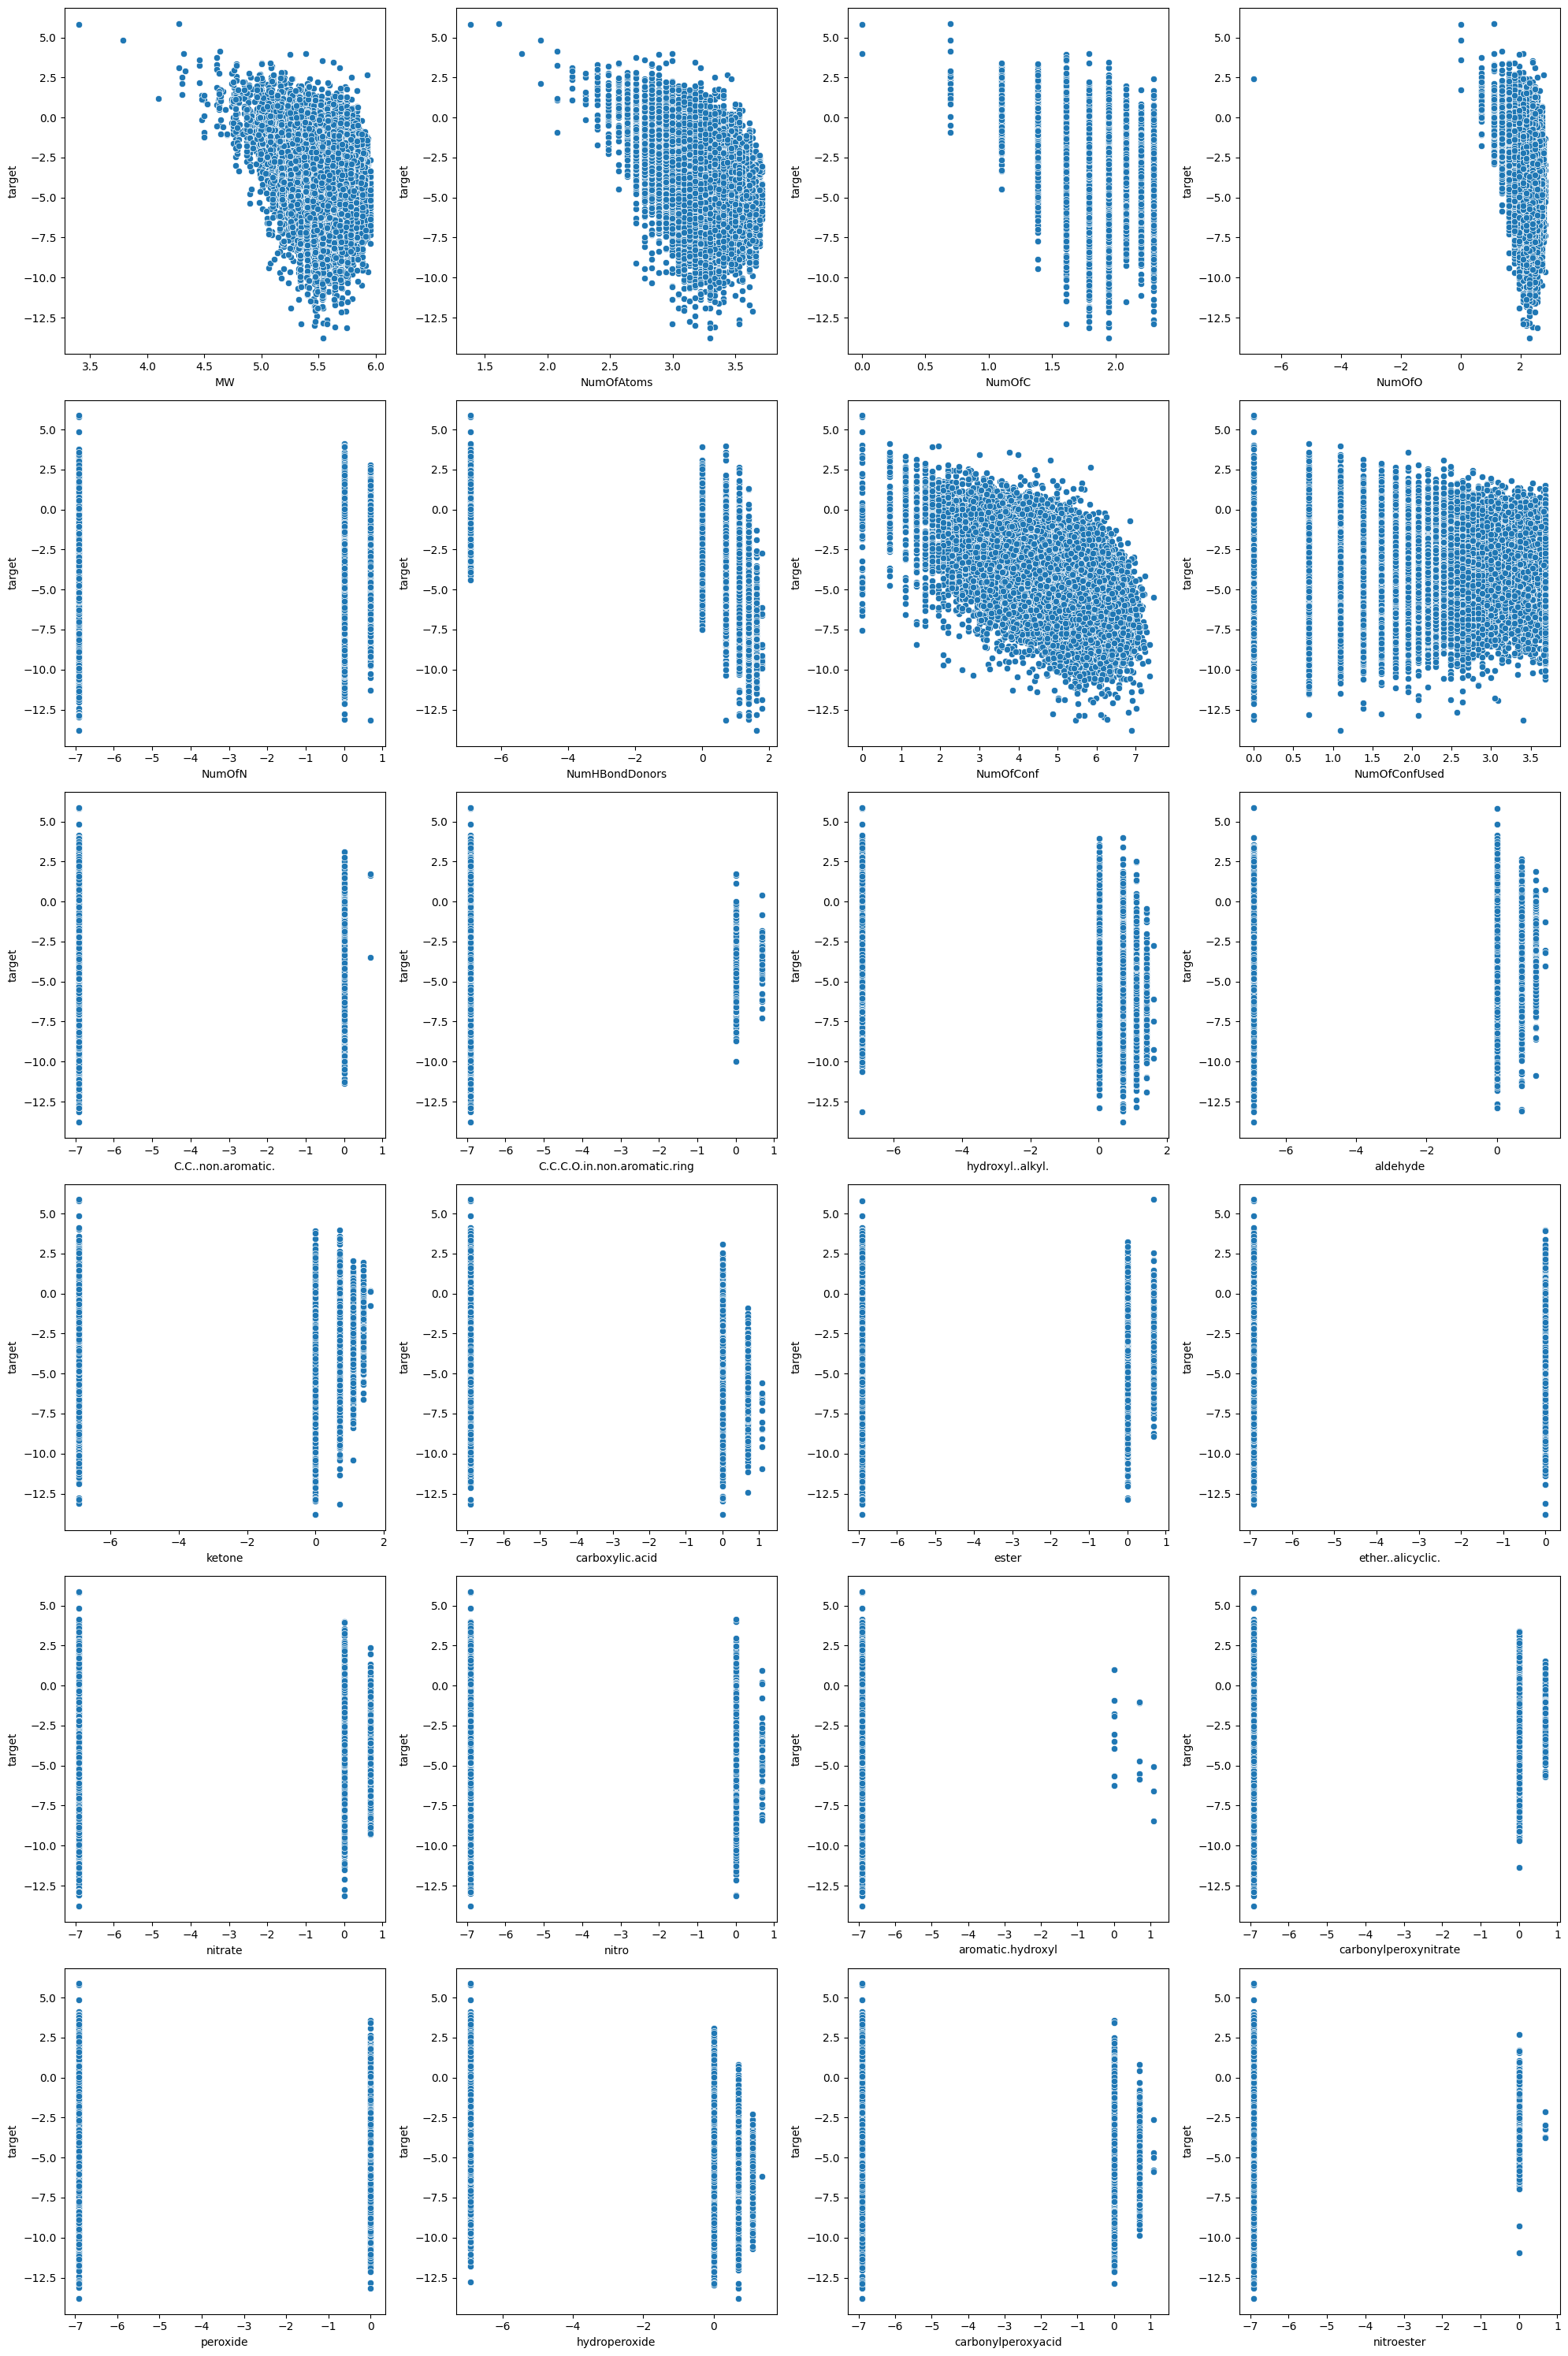

In [9]:

features = [col for col in df.columns if (col != 'target') & (col != 'parentspecies')]
n = len(features)
rows = n // 4 if n % 4 == 0 else n // 4 + 1

df_log = pd.DataFrame(columns=features)
df_log[features] = np.log(df[features] + 1e-3)  # add small number to avoid zero

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

for i, feature in enumerate(features):
    sns.scatterplot(x=df_log[feature], y=df['target'], ax=axs[i//4, i%4])


# Remove empty subplots
if n % 4 != 0:
    for i in range(n, rows*4):
        fig.delaxes(axs.flatten()[i])
plt.tight_layout()
plt.show()


## relation of standardized features with the target 

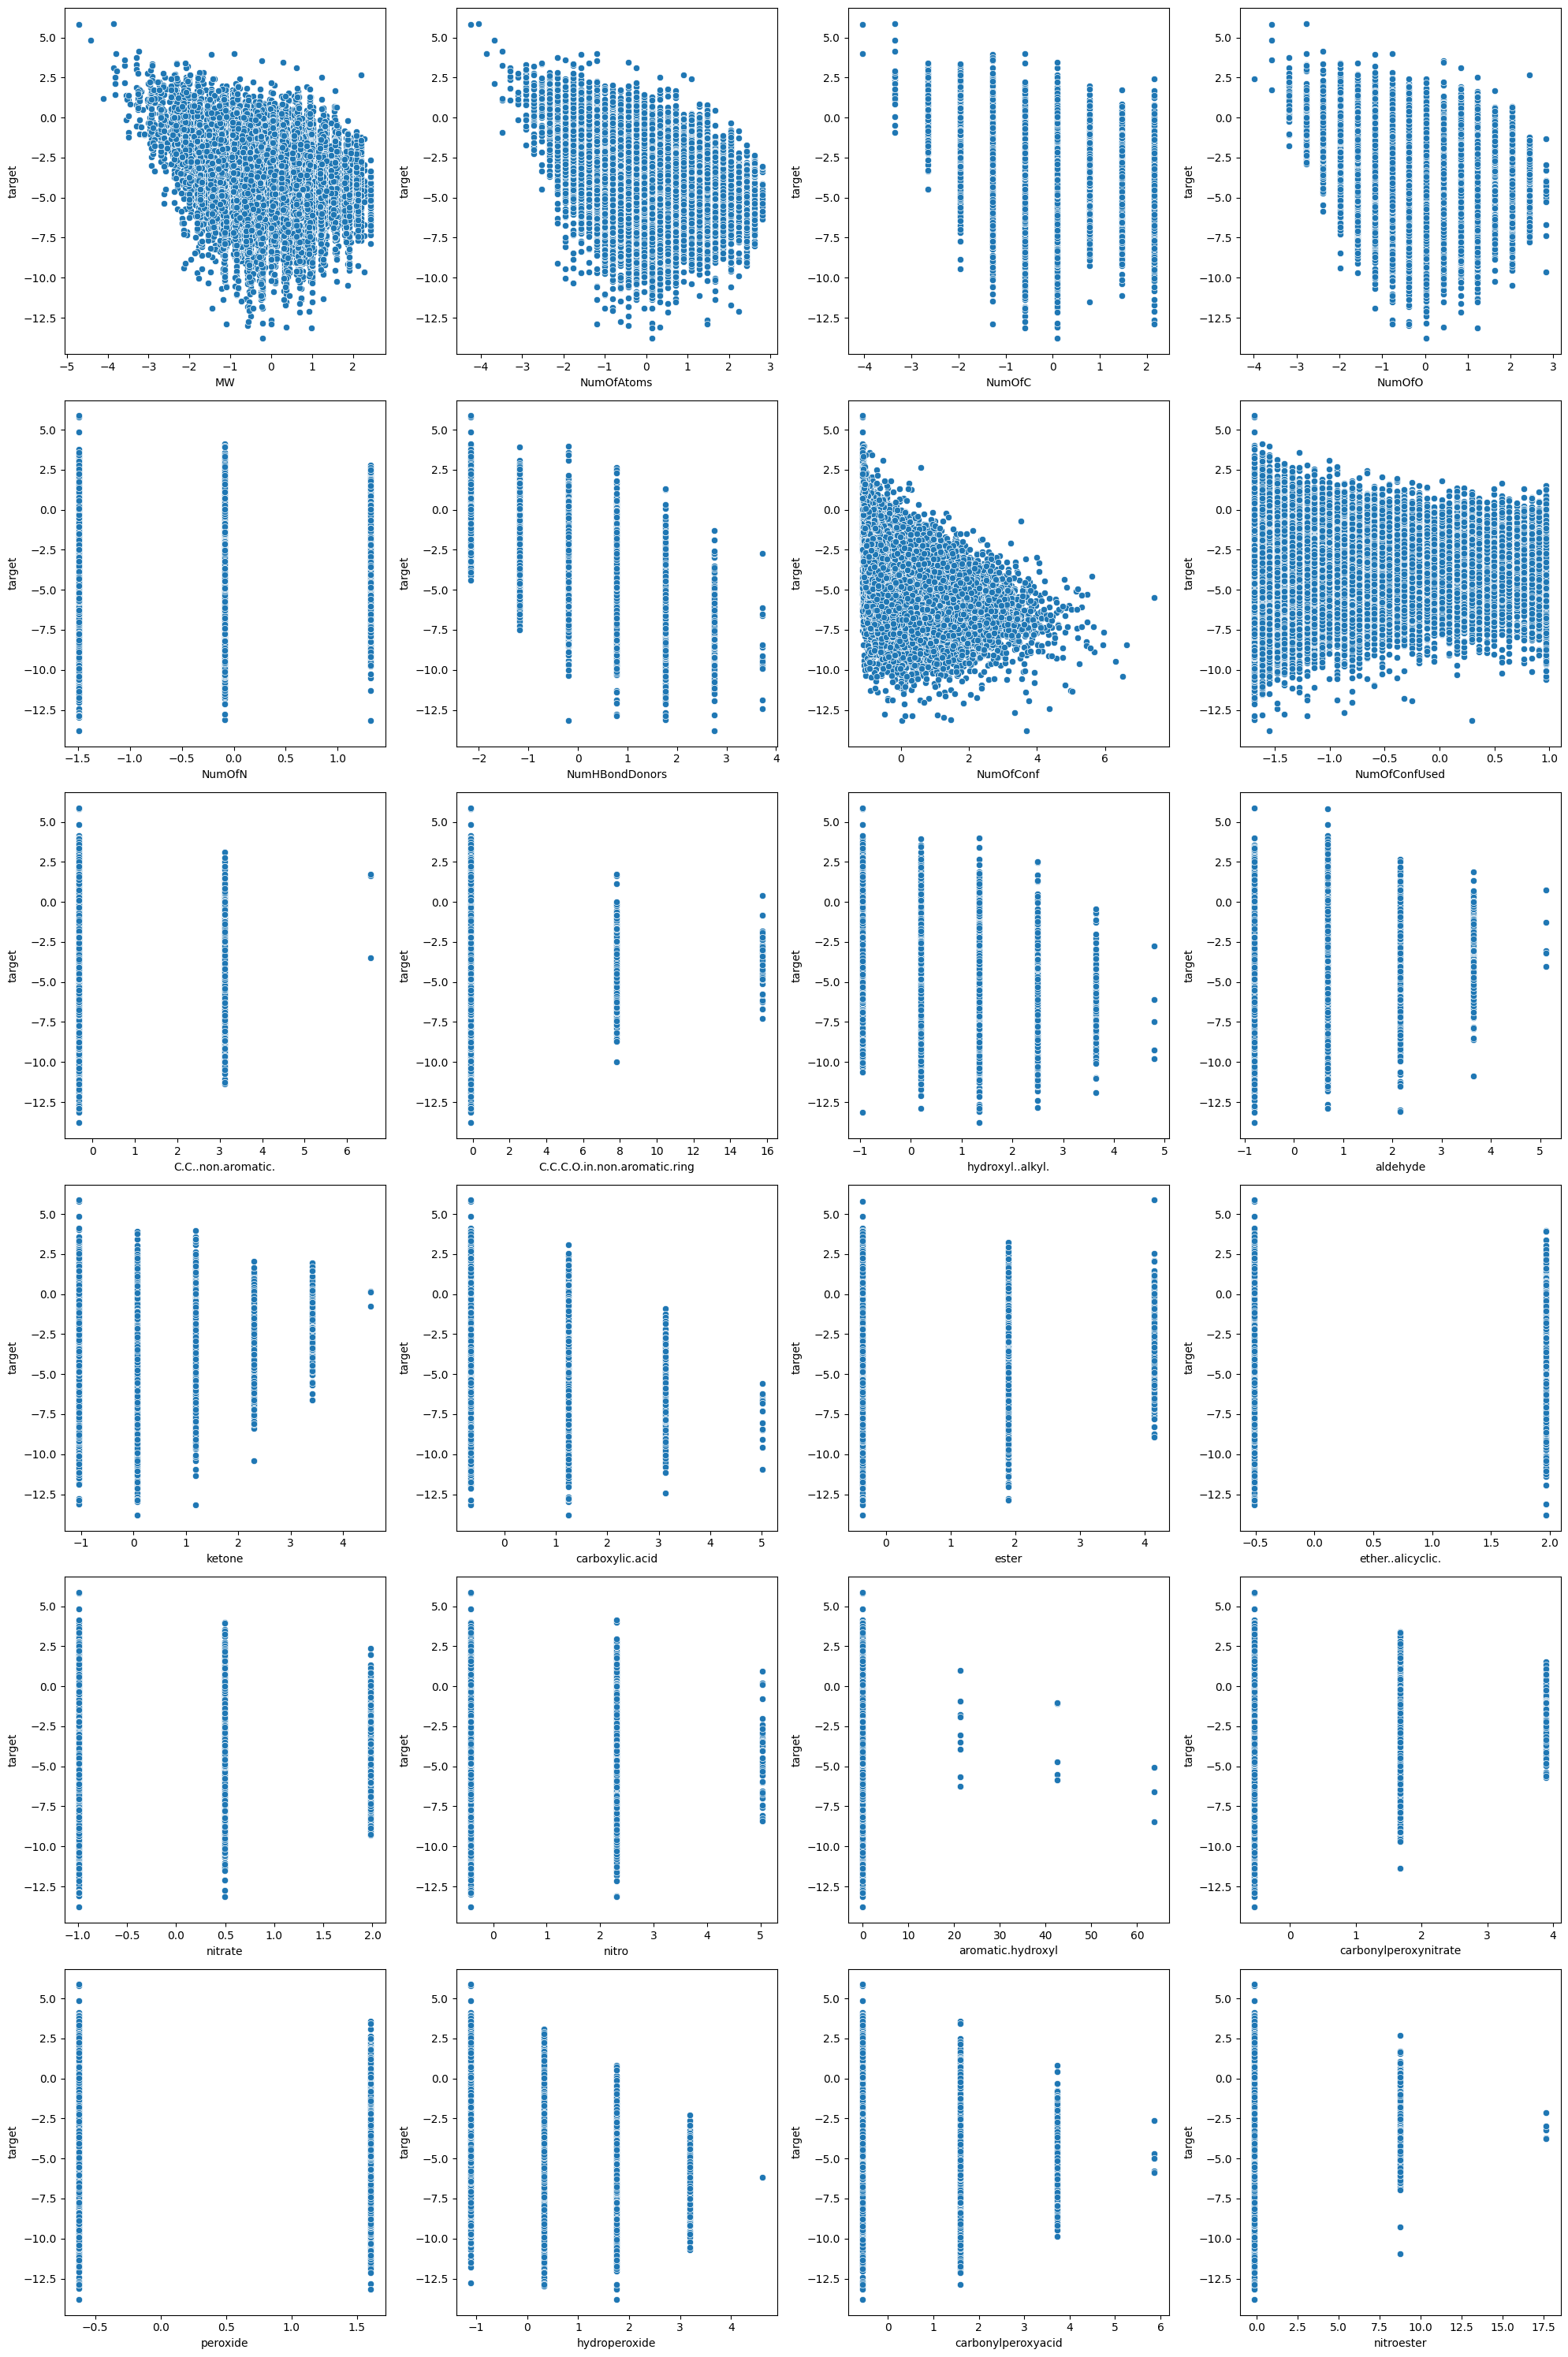

In [10]:


scaler = StandardScaler()
df_standardized =  pd.DataFrame(columns=features)
df_standardized[features] = scaler.fit_transform(df[features])

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

for i, feature in enumerate(features):
    sns.scatterplot(x=df_standardized[feature], y=df['target'], ax=axs[i//4, i%4])

# Remove empty subplots
if n % 4 != 0:
    for i in range(n, rows*4):
        fig.delaxes(axs.flatten()[i])
plt.tight_layout()
plt.show()


## freq of each feature

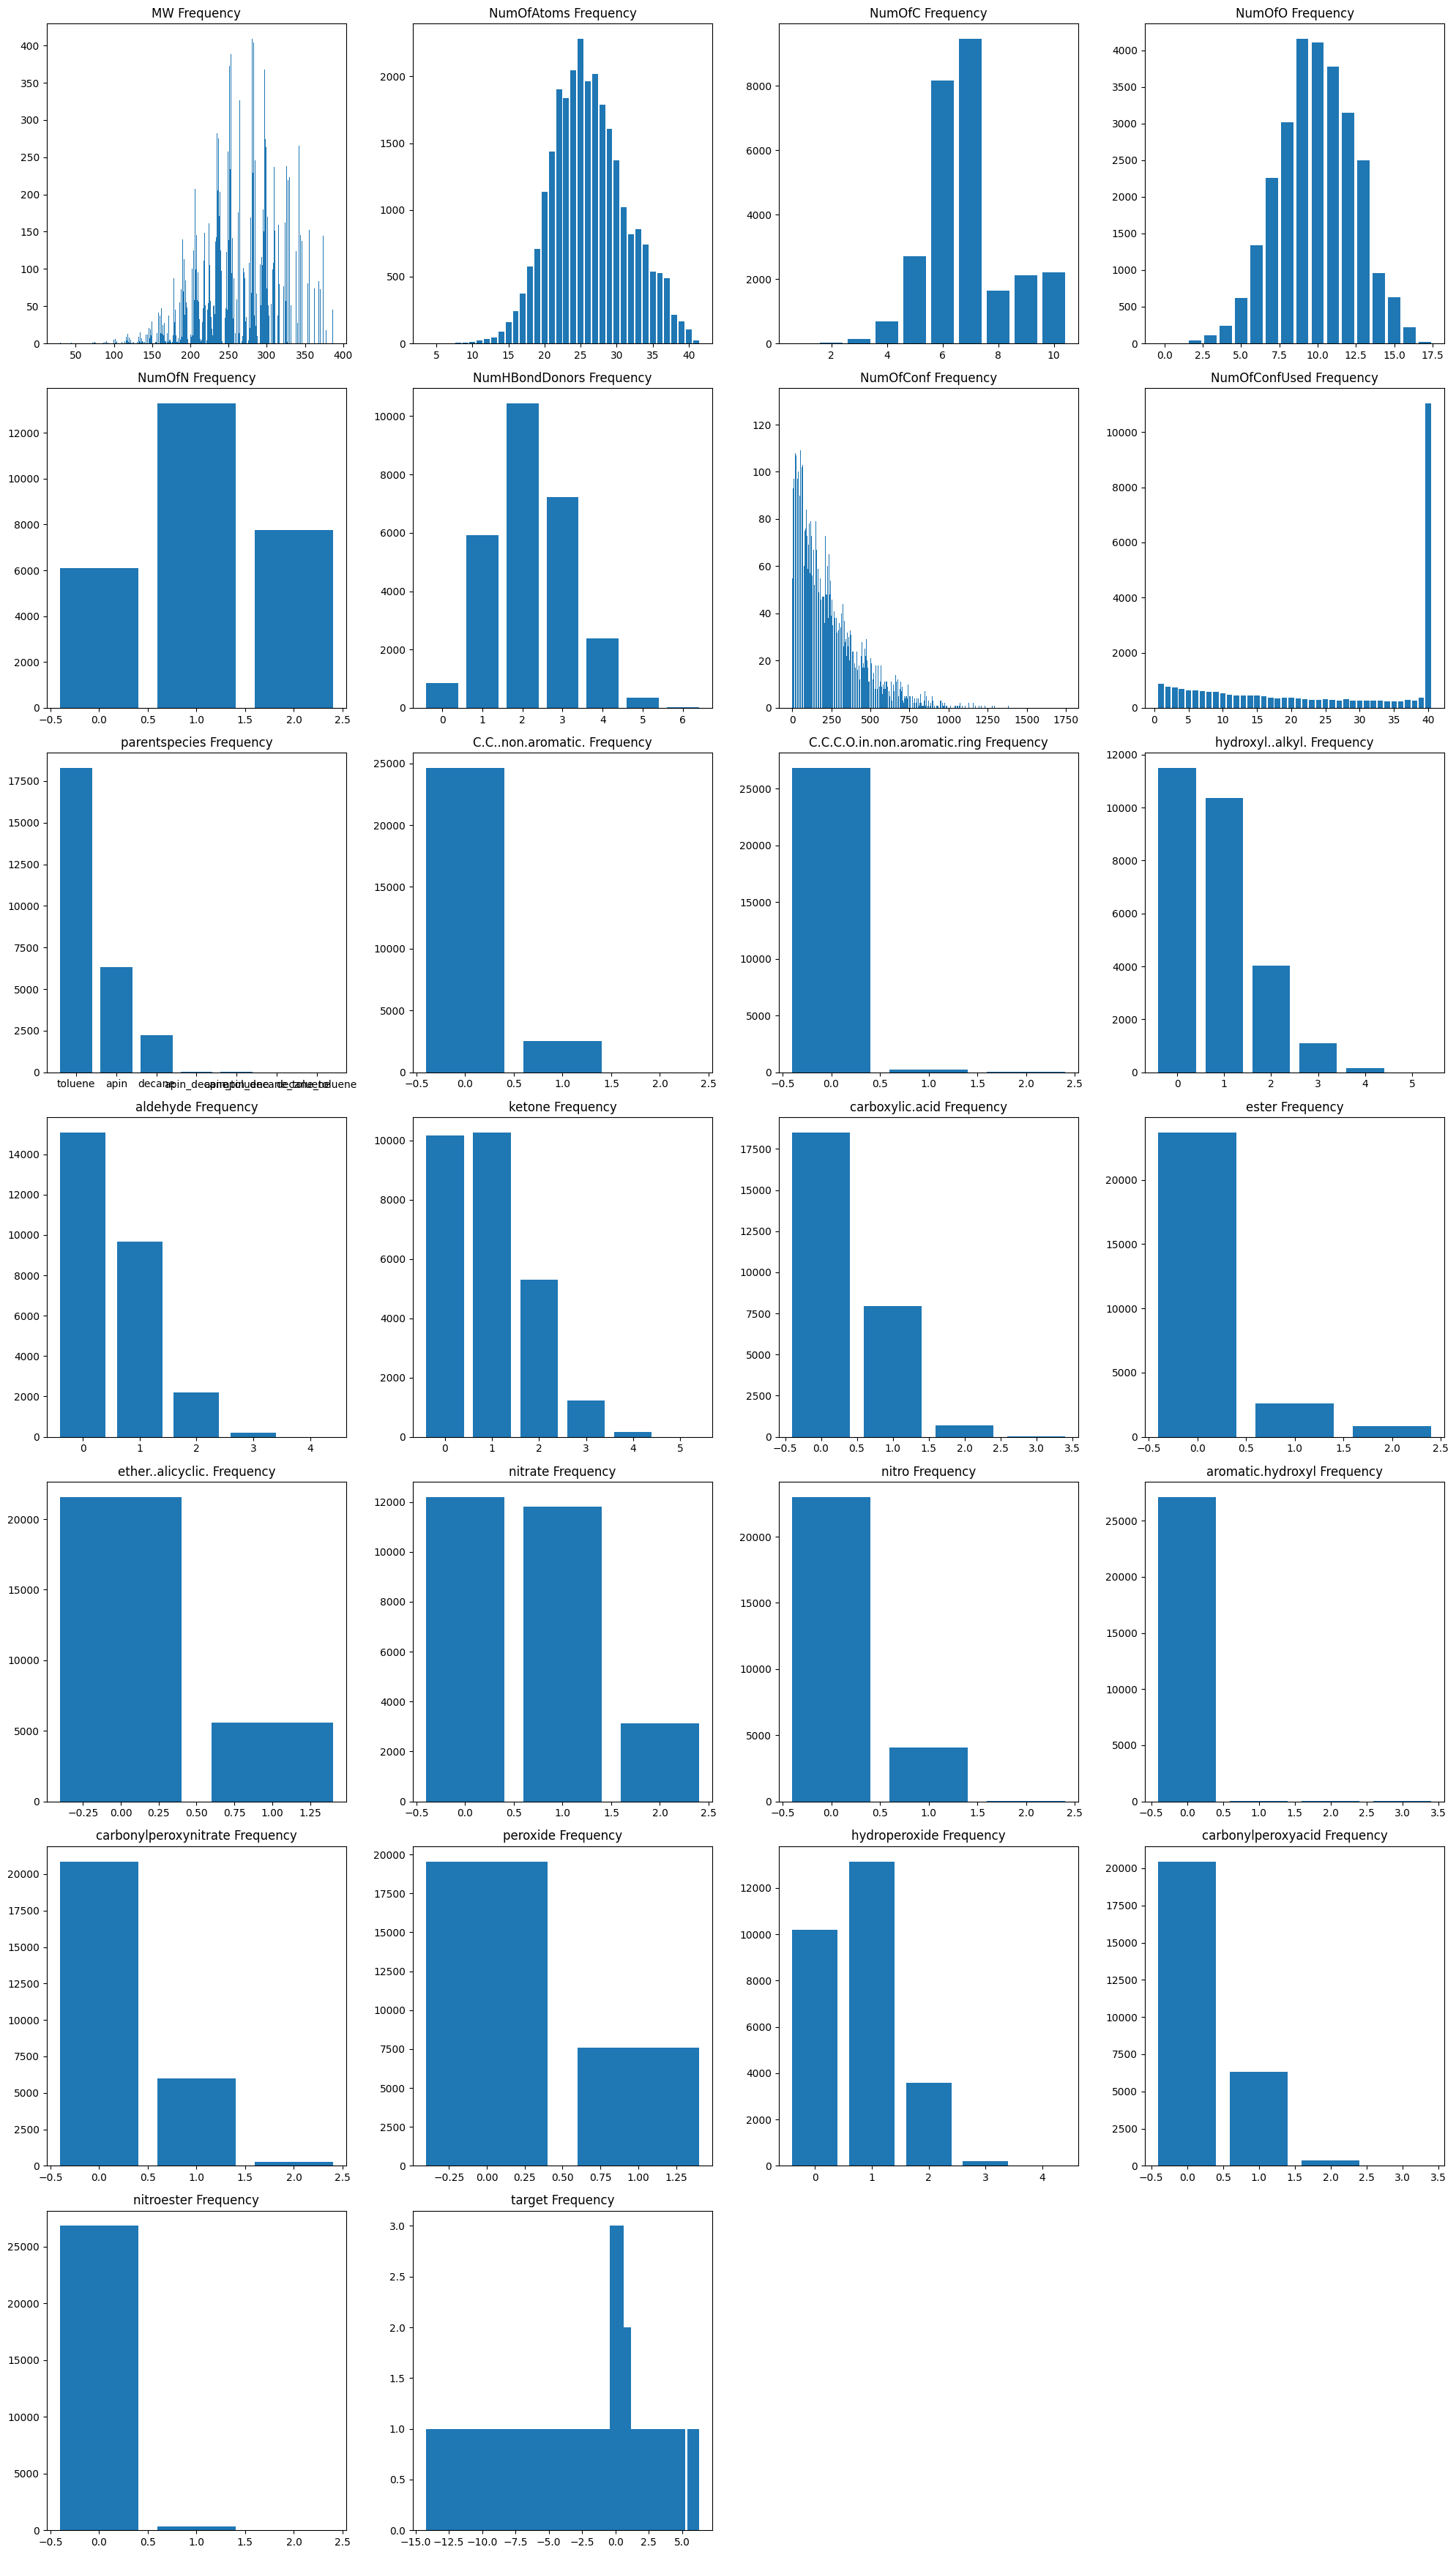

In [11]:
n = len(df.columns)
rows = n // 4 if n % 4 == 0 else n // 4 + 1

fig, axs = plt.subplots(rows, 4, figsize=(20, 5*rows))

for i, col in enumerate(df.columns):
    counts = df[col].value_counts()
    row = i // 4
    col = i % 4
    axs[row, col].bar(counts.index, counts.values)
    axs[row, col].set_title(f'{df.columns[i]} Frequency')

# Remove empty subplots
if n % 4 != 0:
    for i in range(n, rows*4):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


**Correlation Coefficient**: This will give you a measure of how much each feature is linearly related to the target.

As we can see below: all the correlation values are almost neglible. this can be happend because of many reasons
1. Non-linear Relationships
2. Interactions Between Features

I will investigate these more since I believe those have the most effect on the correlation results


In [12]:
# let's check the correlation of numerical data
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlations = df[numerical_features].corr()['target'].drop('target')
print(correlations)

MW                             -0.203743
NumOfAtoms                     -0.307722
NumOfC                         -0.262039
NumOfO                         -0.160683
NumOfN                          0.178995
NumHBondDonors                 -0.689174
NumOfConf                      -0.509059
NumOfConfUsed                   0.038886
C.C..non.aromatic.             -0.046205
C.C.C.O.in.non.aromatic.ring   -0.015391
hydroxyl..alkyl.               -0.306882
aldehyde                        0.054970
ketone                          0.162116
carboxylic.acid                -0.301850
ester                           0.069286
ether..alicyclic.              -0.046708
nitrate                         0.051097
nitro                          -0.015695
aromatic.hydroxyl              -0.003268
carbonylperoxynitrate           0.218945
peroxide                       -0.028923
hydroperoxide                  -0.317614
carbonylperoxyacid             -0.114287
nitroester                      0.049780
Name: target, dt

In [13]:
#let's try to transform all of them to logarithm and check their correlation 
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    if feature != 'target':
        correlation = np.log(df[feature] + 1).corr(df['target'])
        print(f"{feature}   -> {correlation}")
# This made them a bit better

MW   -> -0.23202429219795664
NumOfAtoms   -> -0.33127193039386704
NumOfC   -> -0.2872719047898044
NumOfO   -> -0.1954802754257198
NumOfN   -> 0.17972284770366823
NumHBondDonors   -> -0.6731504245702148
NumOfConf   -> -0.5407808512144318
NumOfConfUsed   -> 0.08434077374387734
C.C..non.aromatic.   -> -0.046524417875804115
C.C.C.O.in.non.aromatic.ring   -> -0.01678337550621867
hydroxyl..alkyl.   -> -0.2967494200879822
aldehyde   -> 0.051762111227640475
ketone   -> 0.15393371956954321
carboxylic.acid   -> -0.29935375951521875
ester   -> 0.06237645955011919
ether..alicyclic.   -> -0.046708311544741574
nitrate   -> 0.0500204955850155
nitro   -> -0.015281028955334239
aromatic.hydroxyl   -> -0.001007336528767615
carbonylperoxynitrate   -> 0.2180449498471754
peroxide   -> -0.028923128386188896
hydroperoxide   -> -0.31016191684073935
carbonylperoxyacid   -> -0.11357921772986107
nitroester   -> 0.050106362545177724


## 

# Feature Engineering and preprocessing

- Based on the visualizations above, we can see that the log transformation is better for scaling data than the standardization
- we need to do hot-encoding for parentspecies
- add interactions (later)

In [14]:
from sklearn.decomposition import PCA
features = [col for col in df.columns if (col != 'target') & (col != 'parentspecies')]

df_encoded=[]

scaler = StandardScaler()
df_standardized =  df.copy()
df_standardized[features] = scaler.fit_transform(df[features])
df_encoded1 = pd.get_dummies(df_standardized, columns=['parentspecies'])
df_encoded1=df_encoded1.drop(columns=["parentspecies_decane_toluene","target"])
df_encoded.append(df_encoded1)

df_log = df.copy()
df_log[features] = np.log(df[features] + 1e-3)  # add small number to avoid zero
df_log[features] = scaler.fit_transform(df_log[features])
df_encoded2 = pd.get_dummies(df_log, columns=['parentspecies'])
df_encoded2=df_encoded2.drop(columns=["parentspecies_decane_toluene","target"])
df_encoded.append(df_encoded2)

df_log10 = df.copy()
df_log10[features] = np.log10(df[features] + 1e-3)  # add small number to avoid zero
df_log10[features] = scaler.fit_transform(df_log10[features])
df_encoded3 = pd.get_dummies(df_log10, columns=['parentspecies'])
df_encoded3=df_encoded3.drop(columns=["parentspecies_decane_toluene","target"])
df_encoded.append(df_encoded3)






# Testing data
df_test=[]
df_test1=pd.read_csv("/kaggle/input/iml_term_project_2023/test.csv")
df_test1[features]=  scaler.fit_transform(df_test1[features])
df_test1 = pd.get_dummies(df_test1, columns=['parentspecies'])
df_test1=df_test1.drop(columns=["Id"])
df_test.append(df_test1)

df_test2=pd.read_csv("/kaggle/input/iml_term_project_2023/test.csv")
df_test2=df_test2.drop(columns=["Id"])
df_test2[features]= np.log(df_test2[features] + 1e-3)
df_test2[features] = scaler.fit_transform(df_test2[features])
df_test2 = pd.get_dummies(df_test2, columns=['parentspecies'])
df_test.append(df_test2)

df_test3=pd.read_csv("/kaggle/input/iml_term_project_2023/test.csv")
df_test3=df_test3.drop(columns=["Id"])
df_test3[features]= np.log10(df_test3[features] + 1e-3)
df_test3[features] = scaler.fit_transform(df_test3[features])
df_test3 = pd.get_dummies(df_test3, columns=['parentspecies'])
df_test.append(df_test3)




# Choose models

## computing R2, errors for models
try standardized data, log data, log10 data


In [15]:
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
models = {
    'OLS': LinearRegression(),
    'RF': RandomForestRegressor(verbose=0,n_estimators=100, max_depth=10, min_samples_split=2, n_jobs=-1),
    'SVR': SVR(verbose=0,shrinking=False),
    'GBR':GradientBoostingRegressor(verbose=0),
    'XGB': XGBRegressor(),
    'LGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0), 
    'ElasticNet': ElasticNet(),
    'SVR_poly': SVR(kernel='poly'),
    'NN':MLPRegressor(hidden_layer_sizes=(32,16,16 ), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.001, max_iter=1000, verbose=False, early_stopping=True, n_iter_no_change=20),

}

In [16]:

def compare_models_table(models,X,y):
    cols=["Regressor", "Train", "Test", "CV", "Train R2", "Test R2"]
    table = pd.DataFrame(columns=cols)

    Train_X, Test_X, Train_y, Test_y = train_test_split(X,y, test_size=0.2, random_state=42)

    for name, model in models.items():
      model.fit(Train_X,Train_y)
      train_pred=model.predict(Train_X)  
      train_loss=mean_squared_error(Train_y,train_pred)
      cv_loss= -cross_val_score(model,X,y,cv=5,scoring='neg_mean_squared_error').mean()

      # Evaluate the model on the test set
      test_pred = model.predict(Test_X)
      test_loss = mean_squared_error(Test_y, test_pred)

      # Calculate R2 scores
      train_r2 = r2_score(Train_y, train_pred)
      test_r2 = r2_score(Test_y, test_pred)

      #update the table
      row = pd.DataFrame([[name, train_loss, test_loss,cv_loss, train_r2, test_r2]], columns=cols)
      table = pd.concat([table, row], ignore_index=True)
      print(name +" Done ")
    return table
    
# table


trying the standardized data

In [17]:
table1=compare_models_table(models,df_encoded[0], df["target"])
table_sorted1 = table1.sort_values(by='Test R2', ascending=False)
table_sorted1

OLS Done 
RF Done 
SVR Done 
GBR Done 
XGB Done 
LGBM Done 
CatBoost Done 
ElasticNet Done 
SVR_poly Done 
NN Done 


,Regressor,Train,Test,CV,Train R2,Test R2
6,CatBoost,0.903649,1.224159,1.284210,0.808771,0.746138
2,SVR,1.099343,1.258761,1.300813,0.767359,0.738962
5,LGBM,1.044587,1.267997,1.318015,0.778946,0.737047
9,NN,1.089982,1.277196,1.370616,0.769340,0.735139
4,XGB,0.760248,1.292980,1.383830,0.839118,0.731866
8,SVR_poly,1.161062,1.304111,1.412361,0.754298,0.729558
3,GBR,1.261005,1.367855,1.393743,0.733148,0.716338
1,RF,1.002525,1.387904,1.444880,0.787848,0.712181
0,OLS,1.390596,1.467745,1.522302,0.705725,0.695624
7,ElasticNet,2.855505,2.902613,2.941651,0.395723,0.398065


trying the log data

In [18]:
table2=compare_models_table(models,df_encoded[1], df["target"])
table_sorted2 = table2.sort_values(by='Test R2', ascending=False)
table_sorted2

OLS Done 
RF Done 
SVR Done 
GBR Done 
XGB Done 
LGBM Done 
CatBoost Done 
ElasticNet Done 
SVR_poly Done 
NN Done 


,Regressor,Train,Test,CV,Train R2,Test R2
6,CatBoost,0.903649,1.224153,1.284220,0.808771,0.746139
5,LGBM,1.041992,1.268730,1.321359,0.779496,0.736895
2,SVR,1.127870,1.276935,1.350130,0.761322,0.735193
9,NN,1.108834,1.283150,1.388334,0.765351,0.733904
4,XGB,0.760248,1.292980,1.383830,0.839118,0.731866
8,SVR_poly,1.183294,1.335624,1.582655,0.749594,0.723022
3,GBR,1.261005,1.367855,1.393417,0.733148,0.716338
1,RF,1.003264,1.387806,1.439274,0.787691,0.712201
0,OLS,1.565530,1.620381,1.871841,0.668705,0.663970
7,ElasticNet,3.592827,3.669267,3.695027,0.239693,0.239079


tring the log10 data

In [19]:
table3=compare_models_table(models,df_encoded[2], df["target"])
table_sorted3 = table3.sort_values(by='Test R2', ascending=False)
table_sorted3

OLS Done 
RF Done 
SVR Done 
GBR Done 
XGB Done 
LGBM Done 
CatBoost Done 
ElasticNet Done 
SVR_poly Done 
NN Done 


,Regressor,Train,Test,CV,Train R2,Test R2
6,CatBoost,0.903649,1.224153,1.284220,0.808771,0.746139
5,LGBM,1.041992,1.268730,1.321359,0.779496,0.736895
2,SVR,1.127870,1.276935,1.350130,0.761322,0.735193
9,NN,1.118372,1.287386,1.803339,0.763332,0.733026
4,XGB,0.760248,1.292980,1.383830,0.839118,0.731866
8,SVR_poly,1.183294,1.335624,1.582655,0.749594,0.723022
3,GBR,1.261005,1.367855,1.393540,0.733148,0.716338
1,RF,1.002588,1.383849,1.441136,0.787834,0.713022
0,OLS,1.565530,1.620381,1.871841,0.668705,0.663970
7,ElasticNet,3.592827,3.669267,3.695027,0.239693,0.239079


## Ensembling

### AdaBoostRegressor

In [20]:
from sklearn.ensemble import AdaBoostRegressor

ensemble = AdaBoostRegressor(
    estimator=CatBoostRegressor(verbose=0),
    n_estimators=15,
    random_state=0
)
Train_X, Test_X, Train_y, Test_y = train_test_split(df_encoded[0], df["target"], test_size=0.2, random_state=42)

ensemble.fit(Train_X, Train_y)

# Make predictions
train_predictions = ensemble.predict(Train_X)
test_predictions = ensemble.predict(Test_X)

# Calculate and print the training and testing errors
train_error = mean_squared_error(Train_y, train_predictions)
test_error = mean_squared_error(Test_y, test_predictions)
print(f'Training Error: {train_error}')
print(f'Testing Error: {test_error}')

# Calculate and print the R2 scores
train_r2 = r2_score(Train_y, train_predictions)
test_r2 = r2_score(Test_y, test_predictions)
print(f'Training R2 Score: {train_r2}')
print(f'Testing R2 Score: {test_r2}')



Training Error: 0.734200484115827
Testing Error: 1.2886098123959888
Training R2 Score: 0.8446298701766465
Testing R2 Score: 0.7327720893042715


### Stacking ensembling

In [21]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
estimators = [
    ('catboost', CatBoostRegressor(verbose=0)),
    ('NN',MLPRegressor(hidden_layer_sizes=(32,16,16 ), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.001, max_iter=1000, verbose=False, early_stopping=True, n_iter_no_change=20)),
    ('lgbm', LGBMRegressor()),
    ('xgb', XGBRegressor()),
    ('GBR',GradientBoostingRegressor(verbose=0)),
    ('RF', RandomForestRegressor(verbose=0)), 
    ('SVR_poly', SVR(kernel='poly')),
    ('OLS',LinearRegression())
]

ensemble = StackingRegressor(
    estimators=estimators,
    final_estimator=LassoCV()
)
Train_X, Test_X, Train_y, Test_y = train_test_split(df_encoded[0], df["target"], test_size=0.2)

ensemble.fit(Train_X, Train_y)


# Make predictions
train_predictions = ensemble.predict(Train_X)
test_predictions = ensemble.predict(Test_X)

# Calculate and print the training and testing errors
train_error = mean_squared_error(Train_y, train_predictions)
test_error = mean_squared_error(Test_y, test_predictions)
print(f'Training Error: {train_error}')
print(f'Testing Error: {test_error}')

# Calculate and print the R2 scores
train_r2 = r2_score(Train_y, train_predictions)
test_r2 = r2_score(Test_y, test_predictions)
print(f'Training R2 Score: {train_r2}')
print(f'Testing R2 Score: {test_r2}')


Training Error: 0.9161161351613715
Testing Error: 1.2103664721661829
Training R2 Score: 0.8066538869381071
Testing R2 Score: 0.7462666593854621


Lasso Coefficients: [ 0.42398793  0.27634671  0.05986842  0.04108998 -0.          0.02680528
  0.17512954  0.00198478]


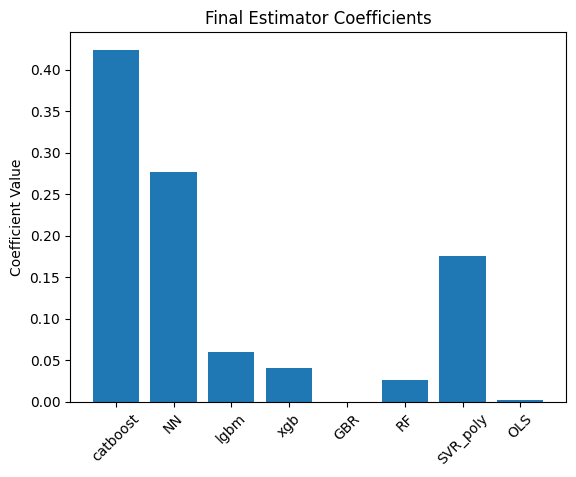

In [22]:
lasso_coef = ensemble.final_estimator_.coef_
print(f'Lasso Coefficients: {lasso_coef}')

# visualize the Final Estimator Coefficients
base_models = [name for name, _ in ensemble.estimators]
final_estimator_coef = ensemble.final_estimator_.coef_


fig, ax = plt.subplots()


ax.bar(base_models, final_estimator_coef)
ax.set_ylabel('Coefficient Value')
ax.set_xticks(np.arange(len(base_models)))
ax.set_xticklabels(base_models, rotation=45)
ax.set_title('Final Estimator Coefficients')

# Show the plot
plt.show()


In [23]:

# catboost_feature_importances = ensemble.named_estimators_['catboost'].get_feature_importance()

# catboost_feature_importances_float = [format(imp, '.3f') for imp in catboost_feature_importances]
# print(f'CatBoost Feature Importances: {catboost_feature_importances_float}')


## Training on the wining model (Stacked ensembling model) and predict the testing data

In [24]:

# ensemble = CatBoostRegressor(verbose=0)
ensemble.fit(df_encoded[0], df["target"])
df_test4=pd.read_csv("/kaggle/input/iml_term_project_2023/test.csv")


predictions = ensemble.predict(df_test[0])
df_test4['target'] = predictions
df_predictions = df_test4[['Id', 'target']]
df_predictions.to_csv('submission.csv', index=False)

